#Object Detection Framework

In [1]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/PramukaWeerasinghe/object_detection_demo'

# Number of training steps.
num_steps = 1000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `object_detection_demo` repository or your fork.

In [3]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 550 (delta 24), reused 29 (delta 13), pack-reused 509
Receiving objects: 100% (550/550), 28.52 MiB | 24.77 MiB/s, done.
Resolving deltas: 100% (272/272), done.
/content/object_detection_demo
Already up to date.


In [4]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


## Install required packages

In [5]:
%cd /content
!git clone https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] = '/content/models/research:/content/models/research/slim:' + os.environ['PYTHONPATH']

!python object_detection/builders/model_builder_test.py

/content
Cloning into 'models'...
remote: Enumerating objects: 38032, done.
remote: Total 38032 (delta 0), reused 0 (delta 0), pack-reused 38032
Receiving objects: 100% (38032/38032), 544.52 MiB | 37.97 MiB/s, done.
Resolving deltas: 100% (25503/25503), done.
Selecting previously unselected package python-bs4.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package pytho

In [ ]:
!pip install tf-slim

## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.
```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt
```

In [6]:
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/object_detection_demo
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Successfully created the TFRecords: /content/object_detection_demo/data/annotations/train.record
Successfully created the TFRecords: /content/object_detection_demo/data/annotations/test.record


In [7]:
test_record_fname = '/content/object_detection_demo/data/annotations/test.record'
train_record_fname = '/content/object_detection_demo/data/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo/data/annotations/label_map.pbtxt'

## Download base model

In [8]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [9]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 63 root   root 4.0K Jul  2 13:16 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [10]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [11]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [12]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [13]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [14]:
!cat {pipeline_fname}
!pwd

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 6
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [15]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [16]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-07-02 13:16:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.84.169.173, 3.223.118.45, 52.201.33.182, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.84.169.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  18.0MB/s    in 0.7s    

2020-07-02 13:16:19 (18.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [17]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [18]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [19]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://261ae6dab903.ngrok.io


In [23]:
!pip install tf-slim

     |████████████████████████████████| 358kB 4.5MB/s 


## Train the model

In [24]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0702 13:16:57.856262 140386528569216 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 1000
I0702 13:16:57.856481 140386528569216 config_util.py:552] Maybe overwriting train_steps: 1000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0702 13:16:57.856582 140386528569216 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0702 13:16:57.856662 140386528569216 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0702 13:16:57.856742 140386528569216 config_util.py:552] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0702 13:16:57.856857 140386528569216 config_util.py:552] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0702 13:16:57.856951 140386528569216 config_util.py:5

In [25]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1593695838.50f7c15ff0fd
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta
model.ckpt-714.data-00000-of-00001
model.ckpt-714.index
model.ckpt-714.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [27]:
import re
import numpy as np

output_directory = './fine_tuned_final_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-1000
Instructions for updating:
Please use `layer.__call__` method instead.
W0702 13:48:37.418488 140485684111232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0702 13:48:38.734418 140485684111232 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0702 13:48:38.747272 140485684111232 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0702 13:48:38.747597 140485684111232 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0702 13:48:38.798544 

In [28]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [29]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [30]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 50M Jul  2 13:48 /content/models/research/fine_tuned_final_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
'''
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
'''

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
'''
from google.colab import files
files.download(pb_fname)
'''

### Download the `label_map.pbtxt` file

In [ ]:
'''
from google.colab import files
files.download(label_map_pbtxt_fname)
'''

### Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
'''
files.download(pipeline_fname)
'''

## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [31]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (3,014 kB/s)
debconf: unable to initi

In [32]:
%cd /content/object_detection_demo/
import wabtec_track

/content/object_detection_demo


In [33]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo/test/4.jpg', '/content/object_detection_demo/test/9.jpg']


/content/models/research/object_detection


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:265: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:250: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:265: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

      type            id  milepost
0   switch                 44.5535
1   switch             ~   44.4650
2   switch        1A\n—*   44.4618
3   switch             =   44.3781
4   switch             =   44.4968
5   switch            Ne   45-9140
6   Signal           ees        []
7   Signal       2\n4N0—   44.4968
8   switch           RSA        []
9   switch             a        []
10  switch             >        []
11  switch            XX        []
12  switch        —*\n1A        []
13  switch       el\n=s4        []
14  switch            aw        []
15  switch             a        []
16  Signal          \aN—        []
17  Signal        ~~\n8S        []
18  Signal  \GN—4 West =        []


<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 216x432 with 0 Axes>

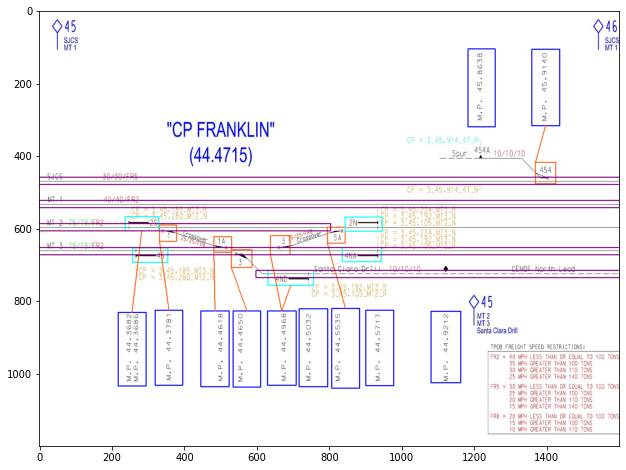

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 72x144 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 216x432 with 0 Axes>

<Figure size 216x432 with 0 Axes>

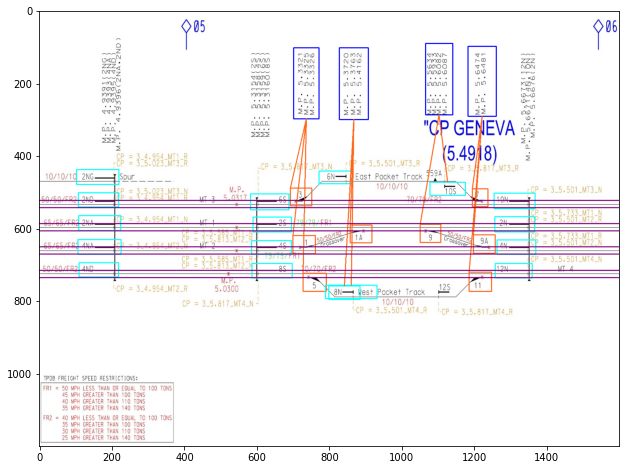

In [41]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import pytesseract
from pytesseract import Output
import shutil
import cv2
import zipfile
import pandas as pd
import wabtec_track

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import files

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

from object_detection.utils import ops as utils_ops
# This is needed to display the images.
%matplotlib inline
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

'''
  To Visualize Initiate the following array
  Array Order ["Switch","Track","Left signal","Right Signal", "all"]
  Ex: If you want bounding boxes only on switches and Tracks
      array should be [1,1,0,0]
'''
visualize = [1,1,1,1,0]

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

s_id = []
milepost = []
s_type = []

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# preprocessing
def switch_preprocess(crop_image):
  kernel = np.ones((3,3),np.uint8)
  gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
  (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  inverse = cv2.bitwise_not(gray)
  closed = cv2.morphologyEx(inverse, cv2.MORPH_CLOSE, kernel)
  #dilation = cv2.dilate(inverse,kernel,iterations = 1)
  dil_inv = cv2.bitwise_not(closed)
  opened = cv2.morphologyEx(dil_inv, cv2.MORPH_OPEN, kernel)
  #opened = cv2.dilate(thresh, kernel, iterations = 1)
  custom_config = r'--oem 3 --psm 6'
  img = Image.fromarray(opened)
  sid = pytesseract.image_to_string(img, config=custom_config)
  return sid

def milestone_preprocess(crop_image):
  gray = cv2.cvtColor(r_img,cv2.COLOR_RGB2GRAY)
  kernel = np.ones((3,3),np.uint8)
  im = np.array(gray * 255, dtype = np.uint8)
  (thresh, gray) = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  #opened = cv2.dilate(thresh, kernel, iterations = 1)
  custom_config = r'--oem 3 --psm 6'
  img = Image.fromarray(gray)
  milestone_id = pytesseract.image_to_string(img, config=custom_config)
  #print(pytesseract.image_to_string(img, config=custom_config))
  return milestone_id

#Draw Bounding boxes
def drawBoundingBoxes(xmin,ymin,xmax,ymax,r,g,b,t):
  x1,y1,x2,y2 = np.int64(xmin * im_width), np.int64(ymin * im_height), np.int64(xmax * im_width), np.int64(ymax * im_height)
  cv2.rectangle(image_np, (x1, y1), (x2, y2), (r, g, b), t)

#Rn Inference on single image
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    #Image to crop labels
    image_to_crop = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.4

    #Obtaining detection boxes, classes and detection scores
    boxes = np.squeeze(output_dict['detection_boxes'])
    scores = np.squeeze(output_dict['detection_scores'])
    classes = np.squeeze(output_dict['detection_classes'])
    #set a min thresh score
    ########
    min_score_thresh = 0.25
    ########
    #Filtering the bounding boxes
    bboxes = boxes[scores > min_score_thresh]
    d_classes = classes[scores > min_score_thresh]
    switch_boxes = bboxes[d_classes == 6]
    milepost_boxes = bboxes[d_classes == 4]
    signal_boxes = bboxes[d_classes == 5]
    crossover_boxes = bboxes[d_classes == 1]
    crossoverLabel_boxes = bboxes[d_classes == 2]
    electSwitch_boxes = bboxes[d_classes == 3]

    #get image size
    im_width, im_height = image.size

    final_box = []
    for box in bboxes:
        ymin, xmin, ymax, xmax = box
        final_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
    #print(final_box)

    if(visualize[0] == 1 or visualize[4] == 1):
      sw_box = []
      for box in switch_boxes:
          ymin, xmin, ymax, xmax = box
          sw_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
          drawBoundingBoxes(xmin,ymin,xmax,ymax,256,100,25,2)

    if(visualize[1] == 1 or visualize[4] == 1):
      signal_box = []
      for box in signal_boxes:
          ymin, xmin, ymax, xmax = box
          signal_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
          drawBoundingBoxes(xmin,ymin,xmax,ymax,0,255,255,2)

    if(visualize[2] == 1 or visualize[4] == 1):
      crossover_box = []
      for box in crossover_boxes:
          ymin, xmin, ymax, xmax = box
          crossover_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
          drawBoundingBoxes(xmin,ymin,xmax,ymax,0,0,255,2)

    if(visualize[3] == 1 or visualize[4] == 1):
      crossoverLabel_box = []
      for box in crossoverLabel_boxes:
          ymin, xmin, ymax, xmax = box
          crossoverLabel_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
          drawBoundingBoxes(xmin,ymin,xmax,ymax,255,0,0,2)

    if(visualize[4] == 1 or visualize[4] == 1):
        electSwitch_box = []
        for box in electSwitch_boxes:
            ymin, xmin, ymax, xmax = box
            electSwitch_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
            drawBoundingBoxes(xmin,ymin,xmax,ymax,120,25,35,2)


    m_box = []
    for box in milepost_boxes:
        ymin, xmin, ymax, xmax = box
        m_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
        drawBoundingBoxes(xmin,ymin,xmax,ymax,0,0,256,2)

    
    #switch
    if(visualize[0] == 1):
      for box in sw_box:
        ymin, xmin, ymax, xmax = box
        y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
        crop_img = image_to_crop[h-10:w+10,y-10:x+10]
        plt.figure(figsize=(1,2))
        #plt.imshow(crop_img) 
        for b in m_box:
            ymin, xmin, ymax, xmax = b
            a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
            val = (y+x)/2
            mid_milepost_x = np.int64((a+c)/2)
            mid_milepost_y = np.int64((b+d)/2)
            if(a<val and val<c ):
              if(h>b):
                cv2.line(image_np, (y,h), (mid_milepost_x,d), (256,100,25), 2)
              else:
                cv2.line(image_np, (y,w), (mid_milepost_x,b), (256,100,25), 2)
              crop_ml = image_to_crop[b-5:d+5,a+5:c-5]
              r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
              plt.figure(figsize=(3,6))
              if '\n' in milestone_preprocess(r_img):
                milepost.append(milestone_preprocess(r_img).split('\ ')[4:14])
              else:
                milepost.append(milestone_preprocess(r_img)[5:14])
              s_id.append(switch_preprocess(crop_img))
              s_type.append("switch")
              #plt.imshow(r_img,cmap='gray') 
      #Corssover Label
      for box in crossover_box:
        ymin, xmin, ymax, xmax = box
        y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
        crop_img = image_to_crop[h-10:w+10,y-10:x+10]
        #plt.figure(figsize=(1,2))
        #plt.imshow(crop_img) 
        for b in m_box:
            ymin, xmin, ymax, xmax = b
            a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
            val = (y+x)/2
            mid_milepost_x = np.int64((a+c)/2)
            mid_milepost_y = np.int64((b+d)/2)
            if(a<val and val<c ):
              if(h>b):
                cv2.line(image_np, (y,h), (mid_milepost_x,d), (256,100,25), 2)
              else:
                cv2.line(image_np, (y,w), (mid_milepost_x,b), (256,100,25), 2)
              crop_ml = image_to_crop[b-5:d+5,a+5:c-5]
              r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
              plt.figure(figsize=(3,6))
              if '\n' in milestone_preprocess(r_img):
                milepost.append(milestone_preprocess(r_img).split('\ ')[4:14])
              else:
                milepost.append(milestone_preprocess(r_img)[5:14])
              s_id.append(switch_preprocess(crop_img))
              s_type.append("Cross Over")
              #plt.imshow(r_img,cmap='gray') 

      #Signal         
      for box in signal_box:
        ymin, xmin, ymax, xmax = box
        y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
        crop_img = image_to_crop[h-10:w+10,y-10:x+10]
        #plt.figure(figsize=(1,2))
        #plt.imshow(crop_img) 
        for b in m_box:
            ymin, xmin, ymax, xmax = b
            a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
            val = (y+x)/2
            v = np.int64(val)
            mid_milepost_x = np.int64((a+c)/2)
            mid_milepost_y = np.int64((b+d)/2)
            if(a<val and val<c ):
              if(h>b):
                cv2.line(image_np, (v,h), (mid_milepost_x,d), (256,100,25), 2)
              else:
                cv2.line(image_np, (v,w), (mid_milepost_x,b), (256,100,25), 2)
              crop_ml = image_to_crop[b-5:d+5,a+5:c-5]
              r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
              plt.figure(figsize=(3,6))
              if '\n' in milestone_preprocess(r_img):
                milepost.append(milestone_preprocess(r_img).split('\ ')[4:14])
              else:
                milepost.append(milestone_preprocess(r_img)[5:14])
              s_id.append(switch_preprocess(crop_img))
              s_type.append("Signal")
              #plt.imshow(r_img,cmap='gray')

      # #left signal
      # if(visualize[2] == 1):
      #   for box in ls_box:
      #     ymin, xmin, ymax, xmax = box
      #     y,h,x,w =  np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
      #     crop_img = image_to_crop[h:w,y:x]
      #     plt.imshow(crop_img) 
      #     for b in m_box:
      #         ymin, xmin, ymax, xmax = b
      #         a,b,c,d = np.int64(ymin), np.int64(ymax),np.int64(xmin), np.int64(xmax)
      #         val = x-5
      #         if(a<val and val<c ):
      #           crop_ml = image_np[b-15:d+15,a-15:c+15]
      #           r_img = cv2.rotate(crop_ml, cv2.ROTATE_90_CLOCKWISE)
      #           plt.figure(figsize=(3,6))
      #           #print(pytesseract.image_to_string(img, config=custom_config))
      #           s_id.append(sid)
      #           s_type.append("left Signal")
      #           if '\n' in milestone_id:
      #             milepost.append(milestone_preprocess(r_img).split('\ ')[4:14])
      #           else:
      #             milepost.append(milestone_preprocess(r_img)[5:14])
      #           #plt.imshow(img,cmap='gray')

     


    
    if(visualize[1]==1 or visualize[4] == 1): 
      t_img = cv2.imwrite('color_img.jpg', image_np)
      wtt = wabtec_track.WabTecTrack(file_name='color_img.jpg')
      tracks = wtt.get_lines()  
      for track in tracks:
        (x1,y1) = track.point_one()
        (x2,y2) = track.point_two()
        cv2.rectangle(image_np, (x1-10, y1-10), (x2+10, y2+10), (128, 0, 128), 2)
       
    #print(category_index)
    #print(d_classes)
    #print(m_box)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

dict = {'type': s_type, 'id':s_id, 'milepost':milepost}
df = pd.DataFrame(dict)
print(df)
# df.to_csv (r'extracted_data.csv', index = False, header=True)
# files.download('extracted_data.csv')